In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.data import DataReader
from datetime import datetime
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [2]:
begin = datetime(2009,1,1)
end = datetime.today()
etrade = DataReader('ETFC','google',begin,end)

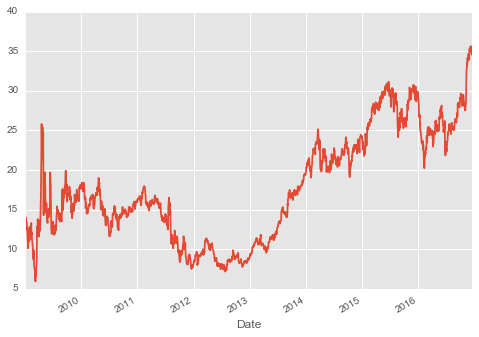

In [3]:
# non-stationary
plt.style.use('ggplot')
etrade['Close'].plot()

In [4]:
# non-stationary (p-value of .74)
adfuller(etrade['Close'])

(-1.0201159442493906,
 0.74585695311788847,
 0L,
 2003L,
 {'1%': -3.4336189466940414,
  '10%': -2.5675387480760885,
  '5%': -2.8629840458358933},
 3217.6981444573412)

C:\Users\Ouisu\Anaconda2\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


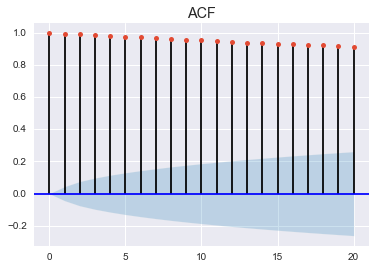

In [14]:
#autocorrelation function
acf = plot_acf(etrade['Close'], lags = 20)
plt.title("ACF")
acf.show()

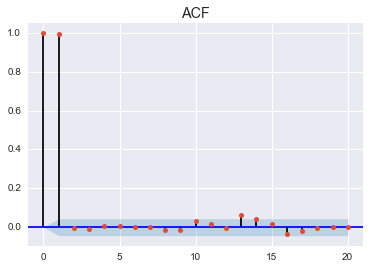

In [15]:
pacf = plot_pacf(etrade['Close'], lags = 20)
plt.title("ACF")
pacf.show()

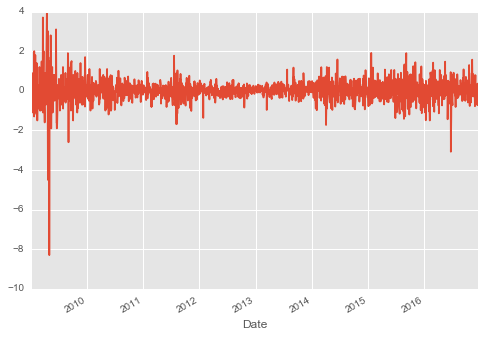

In [5]:
# eliminating trend and seasonality
# taking first difference
# variance different over time
etrade['first_diff'] = etrade['Close'] - etrade['Close'].shift()
etrade['first_diff'].plot()

In [6]:
# stationary (p-value close to 0)
adfuller(etrade['first_diff'].dropna())

(-14.699858211125587,
 2.9583632835996497e-27,
 12L,
 1990L,
 {'1%': -3.4336403292634223,
  '10%': -2.5675437746521554,
  '5%': -2.862993486306054},
 3215.6469727306981)

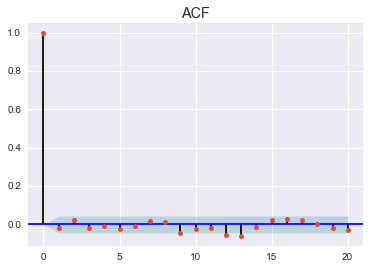

In [19]:
lg_acf = plot_acf(etrade['first_diff'].dropna(), lags = 20)
plt.title("ACF")
lg_acf.show()

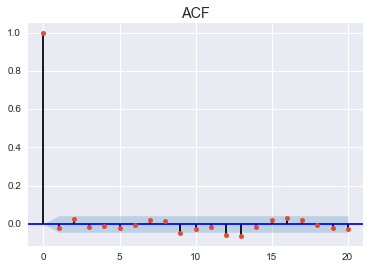

In [20]:
pacf = plot_pacf(etrade['first_diff'].dropna(), lags = 20)
plt.title("ACF")
pacf.show()

In [11]:
# lags: 1,2,10,30 days
etrade['lag1'] = etrade['first_diff'].shift()  
etrade['lag2'] = etrade['first_diff'].shift(2)  
etrade['lag10'] = etrade['first_diff'].shift(10)  
etrade['lag30'] = etrade['first_diff'].shift(30)

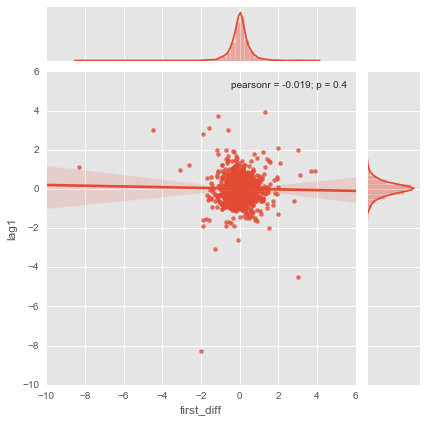

In [12]:
# original vs lagged variable. normally distributed
sns.jointplot('first_diff','lag1',etrade,kind='reg')

In [17]:
# repeating above to find relationships between variable and variable at different lags
lag_corr = acf(etrade['first_diff'].iloc[1:])
lag_partial_corr = pacf(etrade['first_diff'].iloc[1:])

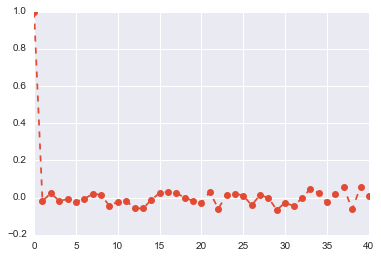

In [23]:
# no correlation between variable and lag. Random walk.
fig, ax = plt.subplots()  
ax.plot(lag_corr, marker='o', linestyle='--')

In [34]:
# Durbin-Watson Statistic. 0-4 range. 2 = no first-order serial corr.
# value < 2: positive serial corr
# value > 2: negative serial corr
print sm.stats.durbin_watson(etrade['Close'])
print sm.stats.durbin_watson(etrade['first_diff'].dropna())

0.00084468364222
2.03604197498


C:\Users\Ouisu\Anaconda2\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


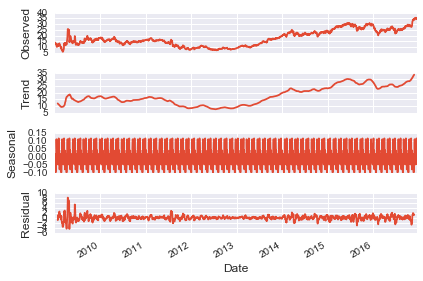

In [24]:
# decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(etrade['Close'], model='additive',freq=30)
fig = plt.figure()
fig = decomposition.plot()

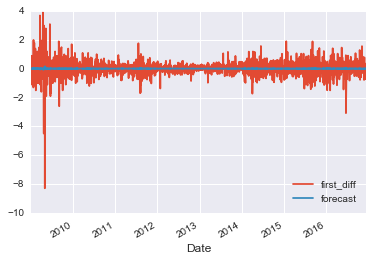

In [25]:
# predicts much smaller variation than actual. reason: random walk. cannot use variable from previous time
# period to predict next day's variable
model = sm.tsa.ARIMA(etrade['first_diff'].iloc[1:],order=(1,0,0))
results = model.fit(disp=-1)
etrade['forecast'] = results.fittedvalues
etrade[['first_diff','forecast']].plot()

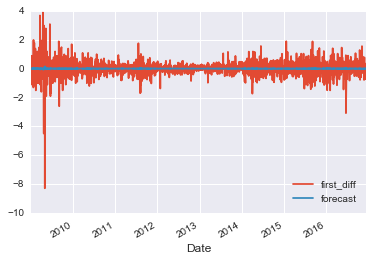

In [26]:
# exponential smoothing model
model = sm.tsa.ARIMA(etrade['first_diff'].iloc[1:],order=(0,0,1))
results = model.fit(disp=-1)
etrade['forecast'] = results.fittedvalues
etrade[['first_diff','forecast']].plot()

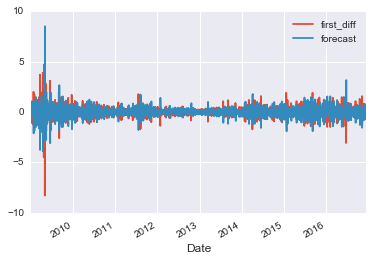

In [99]:
model = sm.tsa.ARIMA(etrade['first_diff'].iloc[1:],order=(1,1,1))
results = model.fit(disp=-1)
etrade['forecast'] = results.fittedvalues
etrade[['first_diff','forecast']].plot()

In [103]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            Log-Likelihood:      -1653.0   
Dependent Variable: D.first_diff     Scale:               1.0000    
Date:               2016-12-19 00:22 Method:              css-mle   
No. Observations:   2002             Sample:              01-06-2009
Df Model:           3                                     12-16-2016
Df Residuals:       1999             S.D. of innovations: 0.551     
AIC:                3313.9445        HQIC:                3322.172  
BIC:                3336.3521                                       
--------------------------------------------------------------------
                    Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const               0.0000   0.0000    0.8794 0.3793 -0.0000  0.0001
ar.L1.D.first_diff -0.0188   0.0224   -0.8392 0.4014 -0.0626  0.0251
ma.L1.D.first_diff -1.0000   0.0013 -750.4722 0.0000 -1.0026 -0.9974
-----------------------------------------------------------------------------
                Real            Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1          -53.2997             0.0000          53.2997             0.5000
MA.1            1.0000             0.0000           1.0000             0.0000
====================================================================

"""

In [48]:
arma_mod20 = sm.tsa.ARIMA(etrade['first_diff'].iloc[1:],order=(1,1,1)).fit()
print arima_mod20.params
print arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic
print sm.stats.durbin_watson(arma_mod20.resid.values)

const          19.524228
ar.L1.Close     0.997664
dtype: float64
3313.94456963 3336.35217747 3322.17175742
2.00218178798


In [60]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

Date
2009-01-06    0.000018
2009-01-07   -0.458415
2009-01-08    1.058878
2009-01-09   -0.511228
2009-01-12    0.163889
dtype: float64


In [61]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()+
print predictions_ARIMA_diff_cumsum.head()

Date
2009-01-06    0.000018
2009-01-07   -0.458397
2009-01-08    0.600482
2009-01-09    0.089254
2009-01-12    0.253143
dtype: float64


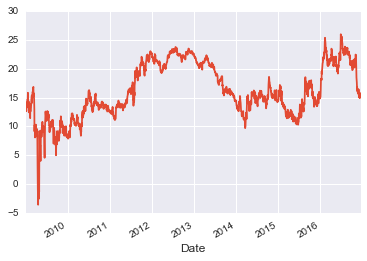

In [108]:
etrade['forecast'] = predictions_ARIMA_diff_cumsum +13.1
etrade['forecast'].plot()

In [107]:
etrade['Close'].head()

Date
2009-01-02    13.1
2009-01-05    13.1
2009-01-06    14.0
2009-01-07    12.9
2009-01-08    13.5
Name: Close, dtype: float64